In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from numpy import log 

torch.manual_seed(123)

The code cell below sets up a general neural network architecture which we can use in the coming problem 

The problem we want to solve is the **1D Absorbing Slab** This is perhaps the simplest problem that we can start with. This system is governed by the radiative transfer equation 




In [77]:

# Generalisable NN
torch.manual_seed(32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed):
        super().__init__()

        # Define size of input and output layers
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define size of hidden layers (number of neurons)
        self.layer_dim = layer_dim

        # Define how many hidden layers
        self.num_hidden = num_hidden

        # Define activation function of neurons
        self.activation = nn.Tanh()

        # Define regularisation parameter
        self.reg_param = reg_param

        # Defin regularisation exponent power
        self.reg_power = reg_power

        # Define random seed to be used
        self.ran_seed = ran_seed

        # Build architectyre
        self.input_layer = nn.Linear(self.input_dim, self.layer_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.layer_dim, self.layer_dim) for _ in range(num_hidden-1)])
        self.output_layer = nn.Linear(self.layer_dim, self.output_dim)
        self.layers = nn.ModuleList([self.input_layer, *self.hidden_layers, self.output_layer])

        # Initialise weights
        self.initialise()

    def forward(self, x):
    # Function defines the forward pass of the network
        for _, f in enumerate(self.layers[:-1]):
            x = self.activation(f(x))
        x = self.output_layer(x)
        return x
    
    def initialise(self):
    # Function defines initilaising the unfrozen weights of the network using Xavier (Glorot) initialisiation
        torch.manual_seed(self.ran_seed)
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                #torch.nn.init.xavier_uniform_(m.weight, gain=g)
                torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
    # Function defines regularisation
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.reg_power)
        return self.reg_param * reg_loss
    
    

Total Loss: 4.2610 | PDE Loss: -0.9306 | Boundary Loss: 1.6999 | Data Loss: 1.2889
Total Loss: 4.2608 | PDE Loss: -0.9303 | Boundary Loss: 1.6998 | Data Loss: 1.2889
Total Loss: 4.2601 | PDE Loss: -0.9290 | Boundary Loss: 1.6994 | Data Loss: 1.2887
Total Loss: 4.2520 | PDE Loss: -0.9153 | Boundary Loss: 1.6951 | Data Loss: 1.2869
Total Loss: 4.1734 | PDE Loss: -0.9856 | Boundary Loss: 1.6538 | Data Loss: 1.2686
Total Loss: 4.0698 | PDE Loss: -0.8641 | Boundary Loss: 1.6019 | Data Loss: 1.2360
Total Loss: 4.0694 | PDE Loss: -0.8640 | Boundary Loss: 1.6018 | Data Loss: 1.2358
Total Loss: 4.0660 | PDE Loss: -0.8634 | Boundary Loss: 1.6003 | Data Loss: 1.2341
Total Loss: 4.0493 | PDE Loss: -0.8625 | Boundary Loss: 1.5933 | Data Loss: 1.2256
Total Loss: 3.8965 | PDE Loss: -1.0148 | Boundary Loss: 1.5361 | Data Loss: 1.1323
Total Loss: 3.8958 | PDE Loss: -1.0157 | Boundary Loss: 1.5359 | Data Loss: 1.1318
Total Loss: 3.8897 | PDE Loss: -1.0243 | Boundary Loss: 1.5337 | Data Loss: 1.1277
Tota

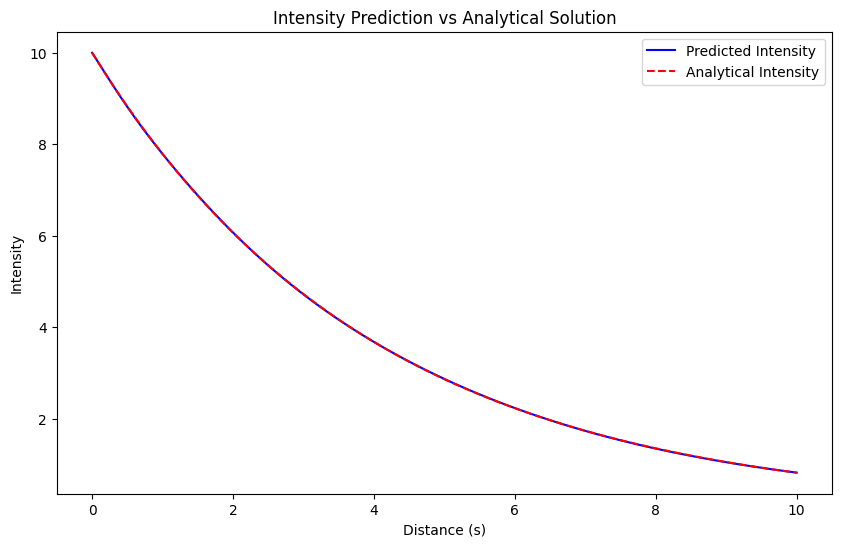

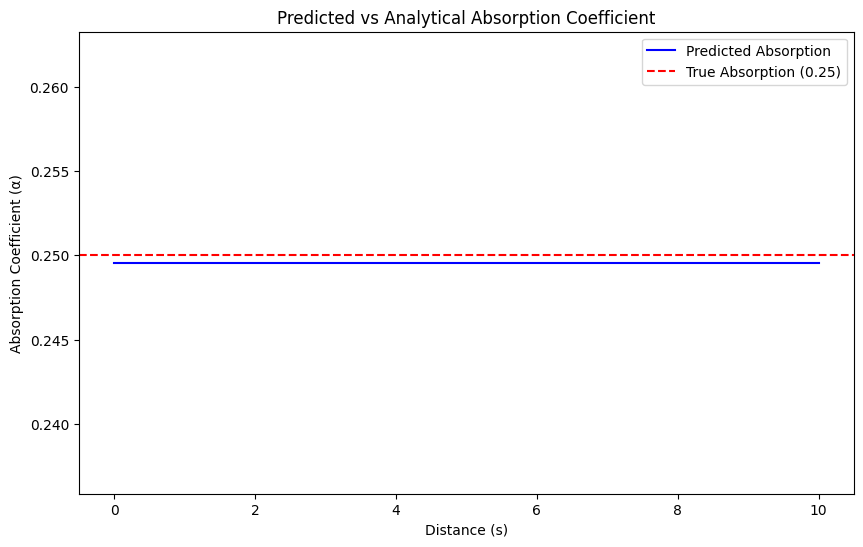

In [87]:
# Define the PINN class
class PINN(nn.Module):
    def __init__(self, balancing_parameter, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed):
        super(PINN, self).__init__()

        # Initialize the NeuralNetwork for intensity and absorption coefficient
        self.intensity_network = NeuralNetwork(input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)
        self.alpha_network = NeuralNetwork(input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)

        self.balancing_parameter = balancing_parameter


    def compute_pde_residual(self, input_distance):
            '''
            Enforces PDE via automatic differentiation.
            Uses NN to predict intensity and absorption, and calculates dI/ds.
            '''
            input_distance.requires_grad = True

            # Predict intensity and absorption coefficient
            pred_intensity = self.intensity_network(input_distance)
            alpha = self.alpha_network(pred_intensity)

            # Compute derivative dI/ds using autograd
            dintensity = torch.autograd.grad(pred_intensity.sum(), input_distance, create_graph=True)[0]

            # PDE residual: dI/ds + alpha * I = 0
            residual = dintensity+ alpha * pred_intensity

            return residual.reshape(-1,)
    
    def compute_loss(self, dist_bound, int_bound, input_distance, input_intensity, verbose=True):
        '''
        Computes loss using boundary conditions, physics residuals, and data loss.
        '''
        # Predict intensity at boundaries
        pred_boundary_intensity = self.intensity_network(dist_bound)

        # Compute PDE residuals (physics enforcement)
        physics_residual = self.compute_pde_residual(input_distance)

        # **Hard enforce boundary conditions**
        boundary_loss = torch.mean((pred_boundary_intensity - int_bound)**2)

        # Compute data residuals inside the slab
        pred_intensity = self.intensity_network(input_distance)
        data_residual = input_intensity - pred_intensity

        # Compute loss terms (L2 loss)
        physics_loss = torch.mean(abs(physics_residual)**2)
        data_loss = torch.mean(abs(data_residual)**2)

        # Add regularization terms
        intensity_reg = self.intensity_network.regularization()
        alpha_reg = self.alpha_network.regularization()
        

        # Total loss (weighted combination)
        total_loss = torch.log(self.balancing_parameter * (data_loss+boundary_loss) + physics_loss + intensity_reg + alpha_reg)
        
        if verbose:
            print(f"Total Loss: {total_loss.item():.4f} | PDE Loss: {torch.log10(physics_loss).item():.4f} | "
                f"Boundary Loss: {torch.log10(boundary_loss).item():.4f} | Data Loss: {torch.log10(data_loss).item():.4f}")
        
        return total_loss
    

# Define the function for the analytical solution
def analytical_solution(input_distance, alpha_value, I0=10.0):
    return I0 * torch.exp(-alpha_value * input_distance)

def plot_results(model, input_distance, analytical_solution, alpha_value):
    # Predict intensity from the trained model
    pred_intensity = model.intensity_network(input_distance).detach()

    # Compute the analytical solution using the true alpha value
    anal_intensity = analytical_solution(input_distance, alpha_value)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(input_distance.detach().numpy(), pred_intensity.detach().numpy(), label='Predicted Intensity', color='b')
    plt.plot(input_distance.detach().numpy(), anal_intensity.detach().numpy(), label='Analytical Intensity', color='r', linestyle='--')
    plt.xlabel('Distance (s)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title('Intensity Prediction vs Analytical Solution')
    plt.show()

    pred_alpha = model.alpha_network(input_distance).detach().numpy().flatten()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(input_distance.detach().numpy(), pred_alpha, label='Predicted Absorption', color='b')
    plt.axhline(y=alpha_value, color='r', linestyle='--', label=f'True Absorption ({alpha_value})')
    plt.xlabel('Distance (s)')
    plt.ylabel('Absorption Coefficient (α)')
    plt.legend()
    plt.title('Predicted vs Analytical Absorption Coefficient')
    plt.show()

def fit(model, optimizer, dist_bound, int_bound, input_distance, input_intensity, epochs):
    '''
    Fits the PINN model using Adam optimization.
    '''
    history = []  # Store loss values

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = model.compute_loss(dist_bound, int_bound, input_distance, input_intensity)
            loss.backward()
            history.append(loss.item())  # Store loss at each epoch
            return loss

        optimizer.step(closure)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {history[-1]:.6f}")

    print(f"Final Loss: {history[-1]:.6f}")

def calculate_relative_l2_error(model, input_distance, analytical_solution, alpha_value):
    """
    Calculates the relative L2 error between the predicted intensity and the analytical solution as a percentage.
    """
    # Predict intensity from the trained model
    pred_intensity = model.intensity_network(input_distance).detach().flatten()

    # Compute the analytical solution using the true alpha value
    anal_intensity = analytical_solution(input_distance, alpha_value).flatten()

    # Compute the L2 norm of the difference between predicted and analytical solutions
    numerator = torch.norm(pred_intensity - anal_intensity, p=2)

    # Compute the L2 norm of the analytical solution
    denominator = torch.norm(anal_intensity, p=2)

    # Compute the relative L2 error as a percentage
    relative_l2_error = (numerator / denominator) * 100

    return relative_l2_error.item()

# ==== Initialize Model and Training ==== 
balancing_parameter = 1.0  # Adjust this if needed
input_dim = 1
output_dim = 1
layer_dim = 20
num_hidden = 6
reg_param = 0.001
reg_power = 1
ran_seed = 32

model = PINN(balancing_parameter, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)

optimizer_Adam = optim.Adam(
    list(model.intensity_network.parameters()) + list(model.alpha_network.parameters()),
    lr=1e-3,  # Adam optimizer typically uses learning rates like this
    betas=(0.5, 0.999),  # Lower momentum for better convergence
    eps=1e-8,  # Small value to prevent division by zero
    weight_decay=0  # LBFGS doesn't typically use weight decay, so keep it 0
)

# Define LBFGS optimizer
optimizer_LBFGS = optim.LBFGS(
    list(model.intensity_network.parameters()) + list(model.alpha_network.parameters()),
    lr=1e-3,
    max_iter=1000,
    max_eval=50000,
    history_size=150,
    line_search_fn="strong_wolfe",
    tolerance_change=np.finfo(float).eps
)

# ==== Training Data (Example Boundaries and Grid Points) ==== 
I0 = 10.0  # Initial intensity
alpha_value = 0.25  # Absorption coefficient

dist_bound = torch.tensor([[0.0], [10.0]])  # Slab distance from 0 to 10
int_bound = torch.tensor([[I0], [I0 * torch.exp(torch.tensor(-alpha_value * 10))]])  # Intensity at boundaries

x_min = dist_bound.min().item()
x_max = dist_bound.max().item()
input_distance = torch.linspace(x_min, x_max, 100).view(-1, 1)  # Interior grid

input_intensity = analytical_solution(input_distance, alpha_value)

# Train the model
fit(model, optimizer_LBFGS, dist_bound, int_bound, input_distance, input_intensity, epochs=10)

# Calculate relative L2 error as a percentage
relative_l2_error = calculate_relative_l2_error(model, input_distance, analytical_solution, alpha_value)
print(f"Relative L2 Error: {relative_l2_error:.6f}%")

# Plot the results **only once** after training
plot_results(model, input_distance, analytical_solution, alpha_value)


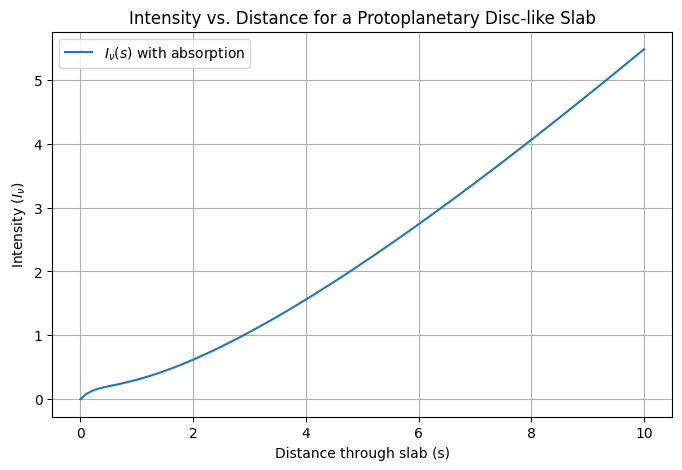

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define parameters
j_nu = 1.0        # Emission coefficient (arbitrary units)
alpha_0 = 5.0     # Central absorption coefficient (optically thick in center)
s_max = 10  
s_min = 0      # Maximum slab thickness (arbitrary units)
num_points = 100  # Number of points for plotting

# Distance array (centered at s=0)
s = np.linspace(s_min, s_max, num_points)

# Define absorption coefficient: optically thick in center, thin outside
def alpha_nu(s):
    return alpha_0 / (1 + s**2)  # Power-law decrease

# Define radiative transfer ODE: dI/ds = j - alpha * I
def radiative_transfer(s, I):
    return j_nu - alpha_nu(s) * I

# Solve ODE numerically using Runge-Kutta (RK45)
I_0 = 0  # Initial intensity at s = -s_max
sol = solve_ivp(radiative_transfer, [s_min, s_max], [I_0], t_eval=s)

# Extract solution
I_nu = sol.y[0]

# Plot results
plt.figure(figsize=(8,5))
plt.plot(s, I_nu, label=r"$I_\nu(s)$ with absorption")
plt.xlabel("Distance through slab (s)")
plt.ylabel("Intensity ($I_\\nu$)")
plt.title("Intensity vs. Distance for a Protoplanetary Disc-like Slab")
plt.legend()
plt.grid(True)
plt.show()
